In [2]:
from sklearn.preprocessing import LabelEncoder
from preprocessor import Preprocessor

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joypy
from ast import literal_eval
from pandas.api.types import is_datetime64_any_dtype

import warnings

In [3]:
parquet = r'./preprocessed.parquet.gzip'
preprocessor = Preprocessor(parquet_path=parquet)
df = preprocessor.get_dataframe()
empties = df['query_template'] == ''
print(f"Removing {sum(empties)} empty query template values.")
df = df[:][~empties]
df.shape

Removing 38 empty query template values.


(759272, 5)

In [4]:
groups = [(qt, gdf) for qt, gdf in df.groupby('query_template')]

selected_group = 2
query_template, gdf = groups[selected_group]
print(query_template)
display(gdf)

DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3


,query_template,query_params,session_line_num,virtual_transaction_id,transaction_id
log_time,,,,,
2022-03-08 11:29:38.190000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3830', '1', '1')",480268,3/16698,0
2022-03-08 11:29:38.191000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3830', '2', '1')",480275,3/16698,56564
2022-03-08 11:29:38.191000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3830', '3', '1')",480282,3/16698,56564
2022-03-08 11:29:38.192000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3830', '4', '1')",480289,3/16698,56564
2022-03-08 11:29:38.192000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3830', '5', '1')",480296,3/16698,56564
...,...,...,...,...,...
2022-03-08 11:29:41.836000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3883', '6', '1')",529250,3/18392,58124
2022-03-08 11:29:41.837000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3883', '7', '1')",529257,3/18392,58124
2022-03-08 11:29:41.837000-05:00,DELETE FROM new_order WHERE NO_O_ID = $1 AND N...,"('3883', '8', '1')",529264,3/18392,58124


In [71]:
# Extract parameters columns. Only deal with numerical or date parameters

# {key=template, value=params_dataframe}
query_to_df_map = {}
# {key=template, value=[p1_dtype, p2_dtype, ...]}
query_to_dtype_map = {}
# {key=template, value=[(p1_mean, p1_var), (p2_mean, p2_var), ...]}
query_to_stats = {}

with warnings.catch_warnings():
  for index, (query_template, tdf) in enumerate(df.groupby('query_template')):
    print(f"******************************************")
    print(index, query_template,)

    print(f"Running for {query_template}...")
    if tdf['query_params'][0] == ():
        continue        

    tdfp = tdf['query_params'].apply(pd.Series)
    tdfp = tdfp.apply(lambda col: col.str.strip("\"'"))

    dtypes = []
    stats = []
    for j, col in enumerate(tdfp):
        try:
            tdfp[col] = pd.to_numeric(tdfp[col], errors='raise')
            dtypes.append("numerical")
            
        except:
            try:
                tdfp[col] = pd.to_datetime(tdfp[col], errors='raise')
                dtypes.append("date")
            except:
                # TODO: Right now we drop non date/numerical columns. Want to handle string columns later
                dtypes.append("string")
                pass
        # Compute mean/var and standardize the column
        if dtypes[-1] != "string":
            # print(f"param {j}, {dtypes[-1]}")
            mean = tdfp[col].mean()
            std = tdfp[col].std()
            # print(mean, std)
            # print(tdfp[col])
            tdfp[col] = (tdfp[col]-mean)/std
            stats.append((mean, std))
        else:
            stats.append(None)
    tdfp = tdfp.convert_dtypes()

    # Store df, dtype, and stats for this template
    query_to_df_map[query_template] = tdfp
    query_to_dtype_map[query_template] = dtypes
    query_to_stats[query_template] = stats

******************************************
0 BEGIN
Running for BEGIN...
******************************************
1 COMMIT
Running for COMMIT...
******************************************
2 DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3
Running for DELETE FROM new_order WHERE NO_O_ID = $1 AND NO_D_ID = $2 AND NO_W_ID = $3...
******************************************
3 INSERT INTO history (H_C_D_ID, H_C_W_ID, H_C_ID, H_D_ID, H_W_ID, H_DATE, H_AMOUNT, H_DATA) VALUES ($1,$2,$3,$4,$5,$6,$7,$8)
Running for INSERT INTO history (H_C_D_ID, H_C_W_ID, H_C_ID, H_D_ID, H_W_ID, H_DATE, H_AMOUNT, H_DATA) VALUES ($1,$2,$3,$4,$5,$6,$7,$8)...
******************************************
4 INSERT INTO new_order (NO_O_ID, NO_D_ID, NO_W_ID) VALUES ( $1, $2, $3)
Running for INSERT INTO new_order (NO_O_ID, NO_D_ID, NO_W_ID) VALUES ( $1, $2, $3)...
******************************************
5 INSERT INTO oorder (O_ID, O_D_ID, O_W_ID, O_C_ID, O_ENTRY_D, O_OL_CNT, O_ALL_LOCAL) VALUE

In [72]:
for qt in query_to_dtype_map.keys():
  print(query_to_dtype_map[qt],query_to_stats[qt])
  print("***************************")

['numerical', 'numerical', 'numerical'] [(3696.0, 304.5665649610596), (5.5, 2.8724174600239913), (1.0, 0.0)]
***************************
['numerical', 'numerical', 'numerical', 'numerical', 'numerical', 'date', 'numerical', 'string'] [(5.525686448184234, 2.864449579017948), (1.0, 0.0), (1168.992736935341, 829.8873732616325), (5.545704162976085, 2.857914969746915), (1.0, 0.0), (Timestamp('2022-03-08 11:29:32.543780608'), Timedelta('0 days 00:00:16.635700527')), (2496.62945309095, 1449.7559260541805), None]
***************************
['numerical', 'numerical', 'numerical'] [(4784.307705206674, 345.18644906091725), (5.517984405131215, 2.8794013090920174), (1.0, 0.0)]
***************************
['numerical', 'numerical', 'numerical', 'numerical', 'date', 'numerical', 'numerical'] [(4784.362233774946, 345.14954765028165), (5.51769243669294, 2.8793454720927163), (1.0, 0.0), (1401.696126111018, 857.7882365013942), (Timestamp('2022-03-08 11:29:32.416972032'), Timedelta('0 days 00:00:16.60405

In [70]:
gg = {k: v for k, v in df.groupby('query_template')}
tdf = gg["SELECT NO_O_ID FROM new_order WHERE NO_D_ID = $1 AND NO_W_ID = $2 ORDER BY NO_O_ID ASC LIMIT $3"]
tdfp = tdf['query_params'].apply(pd.Series)
tdfp = tdfp.apply(lambda col: col.str.strip("\"'"))
tdfp


,0,1,2
log_time,,,
2022-03-08 11:29:38.190000-05:00,1,1,1
2022-03-08 11:29:38.191000-05:00,2,1,1
2022-03-08 11:29:38.191000-05:00,3,1,1
2022-03-08 11:29:38.192000-05:00,4,1,1
2022-03-08 11:29:38.192000-05:00,5,1,1
...,...,...,...
2022-03-08 11:29:41.836000-05:00,6,1,1
2022-03-08 11:29:41.836000-05:00,7,1,1
2022-03-08 11:29:41.837000-05:00,8,1,1


In [65]:
print(list(query_to_df_map.keys())[14])
query_to_df_map[list(query_to_df_map.keys())[14]]

SELECT NO_O_ID FROM new_order WHERE NO_D_ID = $1 AND NO_W_ID = $2 ORDER BY NO_O_ID ASC LIMIT $3


,0,1,2
log_time,,,
2022-03-08 11:29:38.190000-05:00,-1.566625,<NA>,<NA>
2022-03-08 11:29:38.191000-05:00,-1.218486,<NA>,<NA>
2022-03-08 11:29:38.191000-05:00,-0.870347,<NA>,<NA>
2022-03-08 11:29:38.192000-05:00,-0.522208,<NA>,<NA>
2022-03-08 11:29:38.192000-05:00,-0.174069,<NA>,<NA>
...,...,...,...
2022-03-08 11:29:41.836000-05:00,0.174069,<NA>,<NA>
2022-03-08 11:29:41.836000-05:00,0.522208,<NA>,<NA>
2022-03-08 11:29:41.837000-05:00,0.870347,<NA>,<NA>


In [20]:
def graph_query(index, groups):
    qt, gdft = groups[index]
    print("Query:", qt)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for col in gdft:
            meow = gdft[col].to_frame()
            joypy.joyplot(meow.groupby(pd.Grouper(freq="5s")), hist=True, bins=20, overlap=0, grid=True)
            plt.show()

Query: INSERT INTO new_order (NO_O_ID, NO_D_ID, NO_W_ID) VALUES ( $1, $2, $3)


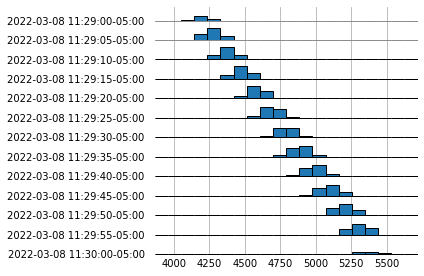

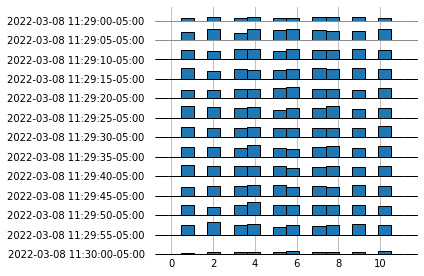

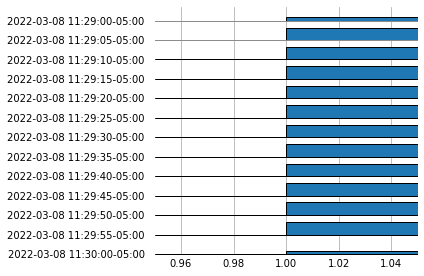

In [21]:
graph_query(2, groups)

# Transform into Time-Series Data

In [23]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Each interval (time step) is vectorized into 4 bins --> [20, 40, 60, 80] percentiles
def left_boundary(x):
  return x.quantile(0.01)
def q1(x):
  return x.quantile(0.1)
def q2(x):
  return x.quantile(0.2)
def q3(x):
  return x.quantile(0.3)
def q4(x):
  return x.quantile(0.4)
def q5(x):
  return x.quantile(0.5)
def q6(x):
  return x.quantile(0.6)
def q7(x):
  return x.quantile(0.7)
def q8(x):
  return x.quantile(0.8)
def q9(x):
  return x.quantile(0.9)
def right_boundary(x):
  return x.quantile(0.99)

# quantiles = [q1, q2, q3, q4, q5, q6, q7, q8, q9]
quantiles = [left_boundary, q1, q2, q3, q4, q5, q6, q7, q8, q9, right_boundary]
quantile_names = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Prediction interval hyperparameters
prediction_interval = pd.Grouper(freq="2s") # Each interval has two seconds
prediction_seq_len = 5 # 5 data points
# total time = interval * seq_len

# Maintain mean and variance of each parameter
means = []
variance = []

In [26]:
gdft_col5 = groups[2][1][0].to_frame()
# Normalize data
mean = gdft_col5.mean().item()
std = gdft_col5.std().item()
gdft_col5_normal = (gdft_col5-mean)/std

# Group by time and get quantile data
time_series_df = gdft_col5_normal.groupby(prediction_interval).agg(quantiles)
display(time_series_df.head())

# results = []
# all_X, all_y, all_X_train, all_X_test, all_y_train, all_y_test = [],[],[],[],[],[]
# for i, quantile in enumerate(quantiles):
#   ########################
#   # Gather training data #
#   ########################
#   lookback_window = int(10/2) # lookback interval / time step
#   X, y = [], []
#   for j in range(lookback_window, len(time_series_df)-1):
#     X.append(time_series_df.iloc[j-lookback_window:j,i].to_numpy())
#     y.append(time_series_df.iloc[j+1, i])
#   X, y = np.array(X), np.array(y)
#   X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

#   all_X.append(X)
#   all_y.append(y)
#   all_X_train.append(X_train)
#   all_X_test.append(X_test)
#   all_y_train.append(y_train)
#   all_y_test.append(y_test)
#   # print(X_train.shape, X.shape, X_test.shape)
#   # print(X[0], y[0])



0                                \
                          left_boundary        q1        q2        q3   
log_time                                                                
2022-03-08 11:29:02-05:00     -1.892449 -1.875241 -1.860176 -1.791228   
2022-03-08 11:29:04-05:00     -1.843374 -1.791228 -1.753567 -1.709533   
2022-03-08 11:29:06-05:00     -1.736012 -1.681143 -1.637688 -1.591916   
2022-03-08 11:29:08-05:00     -1.643076 -1.579748  -1.53977 -1.495156   
2022-03-08 11:29:10-05:00     -1.510047 -1.466766 -1.426208 -1.368848   

                                                                             \
                                 q4        q5        q6        q7        q8   
log_time                                                                      
2022-03-08 11:29:02-05:00 -1.763997 -1.704319 -1.689834 -1.599448 -1.536294   
2022-03-08 11:29:04-05:00 -1.669555 -1.640585 -1.601765 -1.562366 -1.478354   
2022-03-08 11:29:06-05:00 -1.539191 -1.510221  -1.47256 -1.437796 -1.368268   
2022-03-08 11:29:08-05:00  -1.42447 -1.391444 -1.362474 -1.319599 -1.249492   
2022-03-08 11:29:10-05:00 -1.317861 -1.281359 -1.252389 -1.223419 -1.148677   

                                                    
                                 q9 right_boundary  
log_time                                            
2022-03-08 11:29:02-05:00 -1.497474      -1.452455  
2022-03-08 11:29:04-05:00 -1.409985       -1.33362  
2022-03-08 11:29:06-05:00 -1.285994      -1.191726  
2022-03-08 11:29:08-05:00 -1.160844      -1.061594  
2022-03-08 11:29:10-05:00 -1.048441       -0.95707

# Playground

In [ ]:
gdft = gdf['query_params'].apply(literal_eval).apply(pd.Series)
# Remove unneccessary quation marks
gdft = gdft.apply(lambda col: col.str.strip("\"'"))
for col in gdft:
    try:
        gdft[col] = pd.to_datetime(gdft[col], errors='raise')
    except:
        try:
            gdft[col] = pd.to_numeric(gdft[col], errors='raise')
        except:
            pass
gdft = gdft.convert_dtypes()

print(gdft.dtypes)
display(gdft)


In [ ]:
# df = pd.read_csv("parsed_admission/postgres_parsed.csv", parse_dates=["log_time"], index_col=["log_time"])
# empties = df['query_template'] == ''
# print(f"Removing {sum(empties)} empty query template values.")
# df = df[:][~empties]
# print(df.shape)
# df.head()

Removing 0 empty query template values.
(37, 6)


,session_id,session_line_num,virtual_transaction_id,transaction_id,query_template,query_params
log_time,,,,,,
2017-06-25 07:12:57.362167,4811356,0,AAC/4811356/0,NaN,NaN,()
2017-06-25 07:12:57.685996,4811357,0,AAC/4811357/0,NaN,NaN,()
2017-06-25 07:12:57.686190,4811357,1,AAC/4811357/1,NaN,NaN,()
2017-06-25 07:12:57.686832,4811357,2,AAC/4811357/2,NaN,"SELECT expdate,expdate2 FROM systemenv where d...","('1',)"
2017-06-25 07:12:57.695170,4811357,3,AAC/4811357/3,NaN,select content from content where name= $1 and...,"(""'15\\5d3afff71fda95c45e666b77095523a5'"", '1')"
